In [127]:
# 基础数据科学运算库
import numpy as np
import pandas as pd

# 可视化库
import seaborn as sns
import matplotlib.pyplot as plt

# 时间模块
import time

import warnings
warnings.filterwarnings('ignore')

# sklearn库
# 数据预处理
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import normalize,MinMaxScaler,StandardScaler,KBinsDiscretizer


# 损失函数（评估函数）
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,r2_score
from sklearn.model_selection import train_test_split

# 常用评估器
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV,LassoCV,Lasso
from sklearn.svm import SVR
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# 网格搜索
from sklearn.model_selection import GridSearchCV

# 自定义评估器支持模块
from sklearn.base import BaseEstimator, TransformerMixin

# 自定义模块
from telcoFunc import *
# 导入特征衍生模块
import features_creation as fc
from features_creation import *

# re模块相关
import inspect, re

# 其他模块
from tqdm import tqdm
import gc

In [128]:
# 自定义函数输出模型的训练集、测试集的MSE、r2
def result_df(model, X_train, y_train, X_test, y_test, metrics=[mean_squared_error,r2_score]):
    res_train = []
    res_test = []
    col_name = []
    for fun in metrics:
        res_train.append(fun(model.predict(X_train), y_train))
        res_test.append(fun(model.predict(X_test), y_test)) 
        col_name.append(fun.__name__)
    idx_name = ['train_eval', 'test_eval']
    res = pd.DataFrame([res_train, res_test], columns=col_name, index=idx_name)
    return res

# 训练集和测试集
因变量是后一年PCI

In [7]:
train = pd.read_excel('./excel/median_trainDs.xlsx')
test = pd.read_excel('./excel/testDs.xlsx')

In [13]:
# 类别1的训练集和测试集
X_train_1=train.loc[train['cluster']==1,:].drop(columns=['cluster','type','traffic','diff','PCI_contemp'])
y_train_1=train.loc[train['cluster']==1,'PCI_contemp']
X_test_1=test.loc[test['cluster']==1,:].drop(columns=['cluster','type','traffic','diff','PCI_contemp'])
y_test_1=test.loc[test['cluster']==1,'PCI_contemp']

In [15]:
# 类别2的训练集和测试集
# 之后在写，先把类别1搞好

In [86]:
numeric_cols=['shuangdong','dongtu','sunlight','low_tmp','high_tmp','rain','log_traffic', 'PCI_0']

# 一、线性回归

## 1、默认参数

In [102]:
# 设置自变量转化器流
LinearReg_pre = ColumnTransformer([('num', 'passthrough', numeric_cols)])
# 实例化线性回归评估器
LinearReg_model = LinearRegression()
# 设置机器学习流
LinearReg_pipe = make_pipeline(LinearReg_pre, LinearReg_model)
# 模型拟合
LinearReg_pipe.fit(X_train_1, y_train_1)
# 模型拟合效果
print("训练集r2:",LinearReg_pipe.score(X_train_1, y_train_1) )
print("测试集r2:",LinearReg_pipe.score(X_test_1, y_test_1))
result_df(LinearReg_pipe, X_train_1, y_train_1, X_test_1, y_test_1)

训练集r2: 0.9769162680698925
测试集r2: 0.854656333485221


,mean_squared_error,r2_score
train_eval,4.799237,0.976371
test_eval,36.844445,0.886546


## 2、网格搜索超参数
线性回归没有啥值得搜索的超参数
那就来搜索重编码方式吧：结果显示使用最大最小值归一化效果最好。但最终训练误差和测试误差没有任何变化。
结果和默认超参数一摸一样

In [103]:
# 查看超参数在机器学习流中的名字
LinearReg_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('num', 'passthrough',
                                    ['shuangdong', 'dongtu', 'sunlight', 'low_tmp',
                                     'high_tmp', 'rain', 'log_traffic',
                                     'PCI_0'])])),
  ('linearregression', LinearRegression())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('num', 'passthrough',
                                  ['shuangdong', 'dongtu', 'sunlight', 'low_tmp',
                                   'high_tmp', 'rain', 'log_traffic',
                                   'PCI_0'])]),
 'linearregression': LinearRegression(),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transformer_weights': None,
 'columntransformer__transformers': [('num',
   'passthrough',
   ['shuangdong',
    'dongtu',
    'sunlight',
    'low_tmp',
    'h

'linearregression__copy_X': True,
 'linearregression__fit_intercept': True,
 'linearregression__n_jobs': None,
 'linearregression__positive': False
 是线性回归的超参数在机器学习流中的名字，全部都不能搜索

In [105]:
# 设置自变量转化器流
LinearReg_pre_1 = ColumnTransformer([('num', 'passthrough', numeric_cols)])
num_pre = ['passthrough', StandardScaler(), MinMaxScaler(),KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')]
# 实例化线性回归评估器
LinearReg_model_1 = LinearRegression()
# 设置机器学习流
LinearReg_pipe_1 = make_pipeline(LinearReg_pre_1, LinearReg_model_1)
# 设置超参数空间：可以看到把对连续型变量的转换器也算成要搜索的超参数了
LinearReg_param = [{'columntransformer__num':num_pre}]
# 实例化网格搜索评估器
LinearReg_search = GridSearchCV(estimator = LinearReg_pipe_1,
                                  param_grid = LinearReg_param,
                                  n_jobs = 12)
s = time.time()
# 网格搜索评估器模型拟合
LinearReg_search.fit(X_train_1, y_train_1)
print("跑代码用时：",time.time()-s, "s")
print("网格搜索中5折交叉验证的最佳超参数评估器的5个验证集的平均r2：",LinearReg_search.best_score_)
print("最优超参数",LinearReg_search.best_params_)
print("调用最佳参数的机器学习流评估器",LinearReg_search.best_estimator_)
# 最佳评估器拟合效果
result_df(LinearReg_search.best_estimator_, X_train_1, y_train_1, X_test_1, y_test_1)

/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/yy/anaconda3/lib/python3.11/site-packages/sklear

跑代码用时： 0.7743589878082275 s
网格搜索中5折交叉验证的最佳超参数评估器的5个验证集的平均r2： 0.7827796232174136
最优超参数 {'columntransformer__num': MinMaxScaler()}
调用最佳参数的机器学习流评估器 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['shuangdong', 'dongtu',
                                                   'sunlight', 'low_tmp',
                                                   'high_tmp', 'rain',
                                                   'log_traffic', 'PCI_0'])])),
                ('linearregression', LinearRegression())])


,mean_squared_error,r2_score
train_eval,4.799237,0.976371
test_eval,36.844445,0.886546


网格搜索中5折交叉验证的最佳超参数评估器的5个验证集的平均r2 比 最佳超参数评估器在训练集上单次运行得分 更可信

# 二、Ridge回归

## 1、默认参数

In [115]:
# 设置自变量转化器流
Ridge_pre = ColumnTransformer([('num', 'passthrough', numeric_cols)])
# 实例化线性回归评估器
Ridge_model = Ridge()
# 设置机器学习流
Ridge_pipe = make_pipeline(Ridge_pre, Ridge_model)
# 模型拟合
Ridge_pipe.fit(X_train_1, y_train_1)
# 模型拟合效果
print("训练集r2:",Ridge_pipe.score(X_train_1, y_train_1))
print("测试集r2:",Ridge_pipe.score(X_test_1, y_test_1))
result_df(Ridge_pipe, X_train_1, y_train_1, X_test_1, y_test_1)

训练集r2: 0.976907153217873
测试集r2: 0.856382722192514


,mean_squared_error,r2_score
train_eval,4.801132,0.976342
test_eval,36.406808,0.887492


## 2、网格搜索最优超参数、自带的RidgeCV搜索最优超参数
最优Lambda46、29，没啥区别
和默认超参数没啥区别

In [114]:
# 设置自变量转化器流
Ridge_pre_1 = ColumnTransformer([('num', 'passthrough', numeric_cols)])
num_pre = ['passthrough', StandardScaler(), MinMaxScaler(),KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')]
# 实例化线性回归评估器
Ridge_model_1 = Ridge()
# 设置机器学习流
Ridge_pipe_1 = make_pipeline(Ridge_pre_1, Ridge_model_1)
# 设置超参数空间：可以看到把对连续型变量的转换器也算成要搜索的超参数了
Ridge_param = [{'columntransformer__num':num_pre,'ridge__alpha':np.logspace(-5, 8, 200)}]
# 实例化网格搜索评估器
Ridge_search = GridSearchCV(estimator = Ridge_pipe_1,
                                  param_grid = Ridge_param,
                                  n_jobs = 12)
s = time.time()
# 网格搜索评估器模型拟合
Ridge_search.fit(X_train_1, y_train_1)
print("跑代码用时：",time.time()-s, "s")
print("网格搜索中5折交叉验证的最佳超参数评估器的5个验证集的平均r2：",Ridge_search.best_score_)
print("最优超参数",Ridge_search.best_params_)
print("调用最佳参数的机器学习流评估器",Ridge_search.best_estimator_)
# 最佳评估器拟合效果
result_df(Ridge_search.best_estimator_, X_train_1, y_train_1, X_test_1, y_test_1)

/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/yy/anaconda3/lib/python3.11/site-packages/sklear

跑代码用时： 4.612174987792969 s
网格搜索中5折交叉验证的最佳超参数评估器的5个验证集的平均r2： 0.8498462355066376
最优超参数 {'columntransformer__num': 'passthrough', 'ridge__alpha': 46.05922041145113}
调用最佳参数的机器学习流评估器 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['shuangdong', 'dongtu',
                                                   'sunlight', 'low_tmp',
                                                   'high_tmp', 'rain',
                                                   'log_traffic', 'PCI_0'])])),
                ('ridge', Ridge(alpha=46.05922041145113))])


/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


,mean_squared_error,r2_score
train_eval,5.355743,0.973016
test_eval,29.987964,0.898507


1、图像法选最优Lambda

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

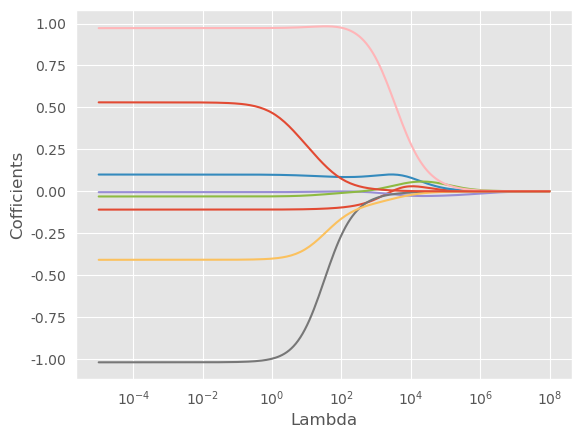

In [108]:
# 1.构造不同的Lambda值
Lambdas = np.logspace(-5, 8, 200)  #Lambda取10的-5次方到10的2次方 
# 2.构造空列表，用于存储不同模型的偏回归系数
ridge_cofficients = []
# 3.循环迭代不同的Lambda值，构造不同的岭回归模型，得到不同回归系数，放入回归系数列表
for Lambda in Lambdas:
    Ridge_model = Ridge(alpha = Lambda)
    Ridge_model.fit(X_train_1, y_train_1)    
    ridge_cofficients.append(Ridge_model.coef_) 
    # 一个模型的回归系数ridge.coef_是8个数字的数组，所以回归系数列表ridge_cofficients里面每个元素是一个数组

# 4.绘制Lambda与回归系数的折线图
# 中文乱码和坐标轴负号的处理
plt.rcParams['axes.unicode_minus'] = False
# 设置绘图风格
plt.style.use('ggplot')
plt.plot(Lambdas, ridge_cofficients) 
     # y轴是ridge_cofficients！是列表，每个元素是数组，每个数组里8个数字，所以一一对应取出相同位置的数字作为一个y值，共8个y值，8条折线
# 对x轴作对数变换  # 这步很重要，虽然我不懂原理
plt.xscale('log')
# 设置折线图x轴和y轴标签
plt.xlabel('Lambda')
plt.ylabel('Cofficients')
# 图形显示
plt.show()

In [74]:
# 2、岭回归模型自带的交叉验证
# 设置交叉验证的参数，对于每一个Lambda值，都执行10重交叉验证
ridge_cv = RidgeCV(alphas = Lambdas, scoring='neg_mean_squared_error', cv = 10)
# 模型拟合
ridge_cv.fit(X_train_1, y_train_1)
# 返回最佳的lambda值
ridge_best_Lambda = ridge_cv.alpha_
ridge_best_Lambda

29.331662783900484

In [109]:
# 3、基于最佳的Lambda值,构建岭回归模型
ridge = Ridge(alpha = ridge_best_Lambda)
ridge.fit(X_train_1, y_train_1)
result_df(ridge, X_train_1, y_train_1, X_test_1, y_test_1)

,mean_squared_error,r2_score
train_eval,5.163711,0.974161
test_eval,30.944200,0.897473


In [110]:
# 返回岭回归系数
pd.Series(index = ['Intercept'] + X_train_1.columns.tolist(),data = [ridge.intercept_] + ridge.coef_.tolist())

Intercept      21.280189
shuangdong     -0.103471
dongtu          0.088925
sunlight       -0.001643
low_tmp        -0.551520
high_tmp       -0.260118
rain           -0.018552
PCI_0           0.983095
log_traffic     0.165838
dtype: float64

# 三、Lasso回归
## 1、默认参数

In [116]:
# 设置自变量转化器流
Lasso_pre = ColumnTransformer([('num', 'passthrough', numeric_cols)])
# 实例化线性回归评估器
Lasso_model = Lasso()
# 设置机器学习流
Lasso_pipe = make_pipeline(Lasso_pre, Lasso_model)
# 模型拟合
Lasso_pipe.fit(X_train_1, y_train_1)
# 模型拟合效果
print("训练集r2:", Lasso_pipe.score(X_train_1, y_train_1))
print("测试集r2:", Lasso_pipe.score(X_test_1, y_test_1))
result_df(Lasso_pipe, X_train_1, y_train_1, X_test_1, y_test_1)

训练集r2: 0.9705675015359378
测试集r2: 0.8818917580024557


,mean_squared_error,r2_score
train_eval,6.119181,0.969279
test_eval,29.940298,0.895353


In [123]:
Lasso_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('num', 'passthrough',
                                    ['shuangdong', 'dongtu', 'sunlight', 'low_tmp',
                                     'high_tmp', 'rain', 'log_traffic',
                                     'PCI_0'])])),
  ('lasso', Lasso())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('num', 'passthrough',
                                  ['shuangdong', 'dongtu', 'sunlight', 'low_tmp',
                                   'high_tmp', 'rain', 'log_traffic',
                                   'PCI_0'])]),
 'lasso': Lasso(),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transformer_weights': None,
 'columntransformer__transformers': [('num',
   'passthrough',
   ['shuangdong',
    'dongtu',
    'sunlight',
    'low_tmp',
    'high_tmp',
    'rain',
    'log_traffic',
   

## 2、网格搜索最优超参数、自带的LassoCV搜索最优超参数
最优Lambda0.9、使用了均值方差标准化，8，没啥区别
和默认超参数没啥区别

In [119]:
# 设置自变量转化器流
Lasso_pre_1 = ColumnTransformer([('num', 'passthrough', numeric_cols)])
num_pre = ['passthrough', StandardScaler(), MinMaxScaler(),
           KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')]
# 实例化线性回归评估器
Lasso_model_1 = Lasso()
# 设置机器学习流
Lasso_pipe_1 = make_pipeline(Lasso_pre_1, Lasso_model_1)
# 设置超参数空间：可以看到把对连续型变量的转换器也算成要搜索的超参数了
Lasso_param = [{'columntransformer__num': num_pre, 'lasso__alpha': np.logspace(-5, 8, 200)}]
# 实例化网格搜索评估器
Lasso_search = GridSearchCV(estimator=Lasso_pipe_1,
                            param_grid=Lasso_param,
                            n_jobs=12)
s = time.time()
# 网格搜索评估器模型拟合
Lasso_search.fit(X_train_1, y_train_1)
print("跑代码用时：", time.time() - s, "s")
print("网格搜索中5折交叉验证的最佳超参数评估器的5个验证集的平均r2：", Lasso_search.best_score_)
print("最优超参数", Lasso_search.best_params_)
print("调用最佳参数的机器学习流评估器", Lasso_search.best_estimator_)
# 最佳评估器拟合效果
result_df(Lasso_search.best_estimator_, X_train_1, y_train_1, X_test_1, y_test_1)

/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/yy/anaconda3/lib/python3.11/site-packages/sklear

跑代码用时： 7.064683198928833 s
网格搜索中5折交叉验证的最佳超参数评估器的5个验证集的平均r2： 0.8941624845460522
最优超参数 {'columntransformer__num': StandardScaler(), 'lasso__alpha': 0.9221978823334341}
调用最佳参数的机器学习流评估器 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['shuangdong', 'dongtu',
                                                   'sunlight', 'low_tmp',
                                                   'high_tmp', 'rain',
                                                   'log_traffic', 'PCI_0'])])),
                ('lasso', Lasso(alpha=0.9221978823334341))])


/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


,mean_squared_error,r2_score
train_eval,8.325580,0.952471
test_eval,32.966658,0.859584


1、图像法选最优Lambda

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

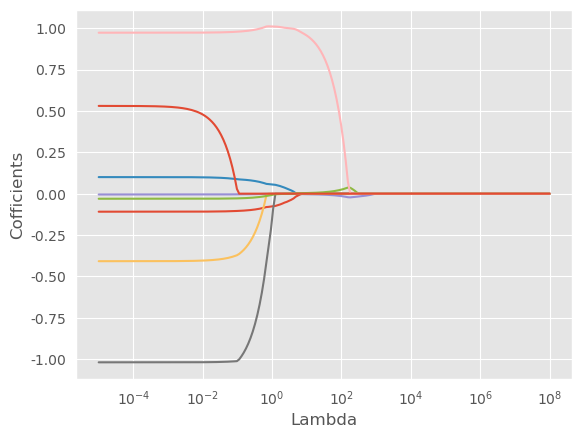

In [120]:
# 1.构造不同的Lambda值
Lambdas = np.logspace(-5, 8, 200)  #Lambda取10的-5次方到10的2次方 
# 2.构造空列表，用于存储不同模型的偏回归系数
Lasso_cofficients = []
# 3.循环迭代不同的Lambda值，构造不同的岭回归模型，得到不同回归系数，放入回归系数列表
for Lambda in Lambdas:
    Lasso_model = Lasso(alpha=Lambda)
    Lasso_model.fit(X_train_1, y_train_1)
    Lasso_cofficients.append(Lasso_model.coef_)
    # 一个模型的回归系数Lasso.coef_是8个数字的数组，所以回归系数列表Lasso_cofficients里面每个元素是一个数组

# 4.绘制Lambda与回归系数的折线图
# 中文乱码和坐标轴负号的处理
plt.rcParams['axes.unicode_minus'] = False
# 设置绘图风格
plt.style.use('ggplot')
plt.plot(Lambdas, Lasso_cofficients)
# y轴是Lasso_cofficients！是列表，每个元素是数组，每个数组里8个数字，所以一一对应取出相同位置的数字作为一个y值，共8个y值，8条折线
# 对x轴作对数变换  # 这步很重要，虽然我不懂原理
plt.xscale('log')
# 设置折线图x轴和y轴标签
plt.xlabel('Lambda')
plt.ylabel('Cofficients')
# 图形显示
plt.show()


In [121]:
# 2、岭回归模型自带的交叉验证
# 设置交叉验证的参数，对于每一个Lambda值，都执行10重交叉验证
Lasso_cv = LassoCV(alphas=Lambdas, cv=10)
# 模型拟合
Lasso_cv.fit(X_train_1, y_train_1)
# 返回最佳的lambda值
Lasso_best_Lambda = Lasso_cv.alpha_
Lasso_best_Lambda


8.804883581643464

In [122]:
# 3、基于最佳的Lambda值,构建岭回归模型
Lasso = Lasso(alpha=Lasso_best_Lambda)
Lasso.fit(X_train_1, y_train_1)
result_df(Lasso, X_train_1, y_train_1, X_test_1, y_test_1)


,mean_squared_error,r2_score
train_eval,7.780300,0.957499
test_eval,31.973268,0.868810


In [124]:
# 返回岭回归系数
pd.Series(index=['Intercept'] + X_train_1.columns.tolist(), data=[Lasso.intercept_] + Lasso.coef_.tolist())

Intercept      3.310170
shuangdong    -0.000000
dongtu         0.000000
sunlight      -0.003271
low_tmp       -0.000000
high_tmp      -0.000000
rain           0.003332
PCI_0          0.962337
log_traffic    0.000000
dtype: float64

# 四、支持向量机
## 1、默认超参数

In [131]:
# 设置自变量转化器流
SVM_pre = ColumnTransformer([('num', 'passthrough', numeric_cols)])
# 实例化线性回归评估器
SVM_model = SVR()
# 设置机器学习流
SVM_pipe = make_pipeline(SVM_pre, SVM_model)
# 模型拟合
SVM_pipe.fit(X_train_1, y_train_1)
# 模型拟合效果
print("训练集r2:",SVM_pipe.score(X_train_1, y_train_1) )
print("测试集r2:",SVM_pipe.score(X_test_1, y_test_1))
result_df(SVM_pipe, X_train_1, y_train_1, X_test_1, y_test_1)

训练集r2: -0.002738631329685548
测试集r2: -0.7601305599402768


,mean_squared_error,r2_score
train_eval,208.474959,-24717.256665
test_eval,446.190986,-62694.300247


## 2、网格搜索最优超参数
OK，默认超参数太夸张了，网格搜索出得最优超参数看起来正常点，但也是效果不好

In [132]:
# 查看超参数在机器学习流中的名字
SVM_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('num', 'passthrough',
                                    ['shuangdong', 'dongtu', 'sunlight', 'low_tmp',
                                     'high_tmp', 'rain', 'log_traffic',
                                     'PCI_0'])])),
  ('svr', SVR())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('num', 'passthrough',
                                  ['shuangdong', 'dongtu', 'sunlight', 'low_tmp',
                                   'high_tmp', 'rain', 'log_traffic',
                                   'PCI_0'])]),
 'svr': SVR(),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transformer_weights': None,
 'columntransformer__transformers': [('num',
   'passthrough',
   ['shuangdong',
    'dongtu',
    'sunlight',
    'low_tmp',
    'high_tmp',
    'rain',
    'log_traffic',
    'PCI_0'

In [133]:
# 设置自变量转化器流
SVM_pre_1 = ColumnTransformer([('num', 'passthrough', numeric_cols)])
num_pre = ['passthrough', StandardScaler(), MinMaxScaler(),KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')]
# 实例化线性回归评估器
SVM_model_1 = SVR()
# 设置机器学习流
SVM_pipe_1 = make_pipeline(SVM_pre_1, SVM_model_1)
# 设置超参数空间：可以看到把对连续型变量的转换器也算成要搜索的超参数了
SVM_param = [{'columntransformer__num':num_pre,
              'svr__C': np.arange(100,1000,200),
              'svr__epsilon': np.arange(0.1,1.5,0.2),
              'svr__gamma': np.arange(0.001,0.01,0.002)}]
# 实例化网格搜索评估器
SVM_search = GridSearchCV(estimator = SVM_pipe_1,
                                  param_grid = SVM_param,
                                  n_jobs = 12)
s = time.time()
# 网格搜索评估器模型拟合
SVM_search.fit(X_train_1, y_train_1)
print("跑代码用时：",time.time()-s, "s")
print("网格搜索中5折交叉验证的最佳超参数评估器的5个验证集的平均r2：",SVM_search.best_score_)
print("最优超参数",SVM_search.best_params_)
print("调用最佳参数的机器学习流评估器",SVM_search.best_estimator_)
# 最佳评估器拟合效果
result_df(SVM_search.best_estimator_, X_train_1, y_train_1, X_test_1, y_test_1)

/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/yy/anaconda3/lib/python3.11/site-packages/sklear

跑代码用时： 6.75040078163147 s
网格搜索中5折交叉验证的最佳超参数评估器的5个验证集的平均r2： 0.8435958905708002
最优超参数 {'columntransformer__num': StandardScaler(), 'svr__C': 700, 'svr__epsilon': 0.7000000000000002, 'svr__gamma': 0.001}
调用最佳参数的机器学习流评估器 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['shuangdong', 'dongtu',
                                                   'sunlight', 'low_tmp',
                                                   'high_tmp', 'rain',
                                                   'log_traffic', 'PCI_0'])])),
                ('svr', SVR(C=700, epsilon=0.7000000000000002, gamma=0.001))])


/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/yy/anaconda3/lib/python3.11/site-packages/sklear

,mean_squared_error,r2_score
train_eval,7.770896,0.954786
test_eval,28.467316,0.890831
